# 0 Первичный анализ и предобработка данных

## 1 Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import itertools

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

## 2 Загрузка данных

__Colab__

In [2]:
# from google.colab import drive, files
# drive.mount('/content/drive')

In [3]:
# files.upload()  # Загрузите kaggle.json

In [4]:
# !ls -lha kaggle.json

In [5]:
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

In [6]:
# !chmod 600 /root/.kaggle/kaggle.json
# !pwd

In [7]:
# !kaggle competitions download -c severstal-steel-defect-detection

In [8]:
# !unzip severstal-steel-defect-detection.zip -d /content/dataset

In [9]:
# !cp -r /content/dataset /content/drive/MyDrive/kaggle/severstal/

In [10]:
# train_df = pd.read_csv('dataset/train.csv').sort_values(by=['ImageId'])
# test_df = pd.read_csv('dataset/sample_submission.csv')

In [11]:
# # Определение путей к папкам с изображениями для обучения и тестирования
# train_folder = os.path.join('/content/dataset', '/train_images')
# test_folder = os.path.join('/content/dataset', '/test_images')

__Jupyter__

In [12]:
import os
notebook_path = os.path.abspath("1st-nb-eda.ipynb")

In [13]:
# Тренировочные данные
train_df = pd.read_csv(os.path.join(os.path.dirname(notebook_path), 'train.csv')).sort_values(by=['ImageId'])
test_df =  pd.read_csv(os.path.join(os.path.dirname(notebook_path), 'sample_submission.csv'))

In [14]:
display(train_df.head())
display(test_df.head())
print("train_df, shape:", train_df.shape, "test_df, shape:", test_df.shape)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


,ImageId,EncodedPixels,ClassId
0,0000f269f.jpg,1 409600,0
1,000ccc2ac.jpg,1 409600,0
2,002451917.jpg,1 409600,0
3,003c5da97.jpg,1 409600,0
4,0042e163f.jpg,1 409600,0


train_df, shape: (7095, 3) test_df, shape: (5506, 3)


In [15]:
# Определение путей к папкам с изображениями для обучения и тестирования
train_folder = os.path.join(os.path.dirname(notebook_path), 'train_images')
test_folder = os.path.join(os.path.dirname(notebook_path), 'test_images')

# Создание множеств для хранения имен изображений
train_images_set = set()
test_images_set = set()

# Рекурсивный обход всех файлов и папок в директории
for dirname, _, filenames in os.walk(os.path.dirname(notebook_path)):
    if 'train_images' in dirname:
        train_images_set.update(filenames)
        print(dirname)
        print("Число тренировочных изображений >", len(filenames))
    elif 'test_images' in dirname:
        test_images_set.update(filenames)
        print(dirname)
        print("Число тестовых изображений >", len(filenames))

C:\Users\Admin\Desktop\Kaggle\test_images
Число тестовых изображений > 5506
C:\Users\Admin\Desktop\Kaggle\test_images\.ipynb_checkpoints
Число тестовых изображений > 1
C:\Users\Admin\Desktop\Kaggle\train_images
Число тренировочных изображений > 12568


## 3 Предобработка данных

In [16]:
# Тренировочные уникальные изображения в train_df
train_defect_images_train_df_set = set(train_df['ImageId'].unique())

# Тренировочные уникальные изображения в папке train_images которые отсутствуют в train_df, т.е бездефекта
train_images_no_defect_set = train_images_set - train_defect_images_train_df_set

# Тестовые уникальные изображения в test_df
test_images_set = set(test_df['ImageId'].unique())

In [17]:
print("Общее число тренировочных изображений: ", len(train_images_set))
print("Число уникальных изображений на тренировочных данных c дефектами: ", len(train_defect_images_train_df_set))
print("Число изображений без дефектов на тренировочных данных: ", len(train_images_no_defect_set))

print( "Число уникальных изображений на тестовых данных с дефектами: ", len(test_images_set))

Общее число тренировочных изображений:  12568
Число уникальных изображений на тренировочных данных c дефектами:  6666
Число изображений без дефектов на тренировочных данных:  5902
Число уникальных изображений на тестовых данных с дефектами:  5506


In [18]:
# Создадаим датафрэйм с названиями изображений которые без дефекта
train_images_no_defect_df = pd.DataFrame({"ImageId" : list(train_images_no_defect_set)})
train_images_no_defect_df['defect'] = 0

# Создадим датафрэйм с названиями изображений с дефектом
train_images_defects_df = pd.DataFrame({"ImageId" : list(train_defect_images_train_df_set)})
train_images_defects_df['defect'] = 1

# Объединим датафрэймы
train_defect_flag_df = pd.concat([train_images_no_defect_df, train_images_defects_df], ignore_index=True)

# Сохраним результат
# train_defect_flag_df.to_csv('train_defect_flag.csv', index=False)

In [19]:
display(train_defect_flag_df)
print(train_defect_flag_df.shape)

,ImageId,defect
0,66a1eb528.jpg,0
1,185c3d54f.jpg,0
2,2f2afbcc4.jpg,0
3,d19e7a3c2.jpg,0
4,478dc217a.jpg,0
...,...,...
12563,b2148a422.jpg,1
12564,20bee9bda.jpg,1
12565,400144782.jpg,1
12566,e5dfaf632.jpg,1


(12568, 2)


Посмотрим на изображения

In [20]:
# Соберем полный датафрэйм заменим пропуски значением 0
# ClassId == 0 - новый класс: дефект отсутствует

# 12997 - 429 = 12568
# 5902 + 6239 + 425 + 2 = 12568
# 5902 + 6239 + 425*2 + 2*3 = 12997


full_train_df = train_defect_flag_df.merge(train_df,
                                           on='ImageId',
                                           how='left')\
                                           .reset_index(drop=True).fillna(0)

full_train_df

,ImageId,defect,ClassId,EncodedPixels
0,66a1eb528.jpg,0,0.0,0
1,185c3d54f.jpg,0,0.0,0
2,2f2afbcc4.jpg,0,0.0,0
3,d19e7a3c2.jpg,0,0.0,0
4,478dc217a.jpg,0,0.0,0
...,...,...,...,...
12992,b2148a422.jpg,1,4.0,276386 2 276640 8 276894 13 277148 18 277402 2...
12993,20bee9bda.jpg,1,3.0,107 29 334 60 590 61 846 62 1102 64 1358 65 16...
12994,400144782.jpg,1,3.0,56833 32 57089 96 57345 160 57601 224 57857 35...
12995,e5dfaf632.jpg,1,3.0,94587 7 94831 19 95075 31 95319 43 95563 55 95...


In [21]:
# https://www.kaggle.com/code/paulorzp/rle-functions-run-lenght-encode-decode
def mask2rle(img):
    """
    Преобразование маски (numpy массив) в строку Run-Length Encoding (RLE).

    params:
    img (numpy array): Маска, где 1 - дефект, 0 - фон.

    return:
    str: RLE, представляющая маску.
    """
    # Транспонирование и выравнивание массива в одномерный массив
    pixels = img.T.flatten()
    # Добавление 0 в начало и конец массива для корректного определения границ
    pixels = np.concatenate([[0], pixels, [0]])
    # Определение изменений между соседними пикселями
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    # Вычисление длин участков (runs)
    runs[1::2] -= runs[::2]
    # Преобразование в строку
    return ' '.join(map(str, runs))

def rle2mask(mask_rle, shape=(1600, 256)):
    """
    Преобразование строки Run-Length Encoding (RLE) в маску (numpy массив).

    params:
    mask_rle (str): RLE, представляющая маску.
    shape (tuple): Размер возвращаемого массива (ширина, высота).

    return:
    numpy array: Маска, где 1 - дефект, 0 - фон.
    """
    # Разделение строки RLE на начальные позиции и длины
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    # Начальные позиции уменьшаются на 1 для корректного индексирования
    starts -= 1
    # Определение конечных позиций
    ends = starts + lengths
    # Создание пустого массива заданного размера
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    # Заполнение массива значениями маски
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    # Преобразование одномерного массива в двумерный и транспонирование
    return img.reshape(shape).T

# Тестирование функций RLE
# Проверка корректности преобразования маски в RLE и обратно
assert mask2rle(rle2mask(train_df['EncodedPixels'].iloc[0])) == train_df['EncodedPixels'].iloc[0]
# Проверка корректности для простого примера
assert mask2rle(rle2mask('1 1')) == '1 1'

### 3.1 Визуализация дефектов

Класс дефекта: 1


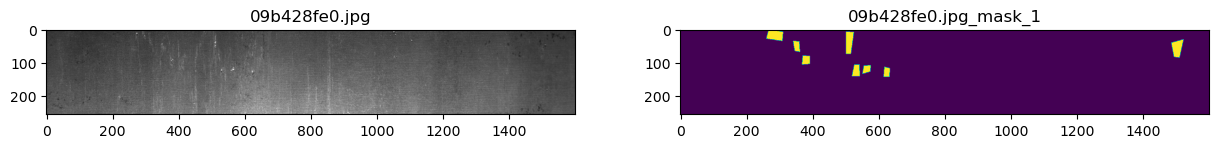

Класс дефекта: 2


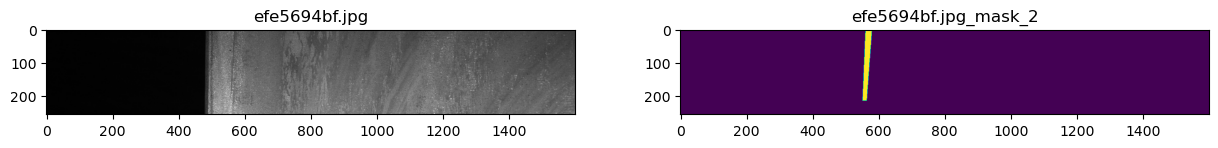

Класс дефекта: 3


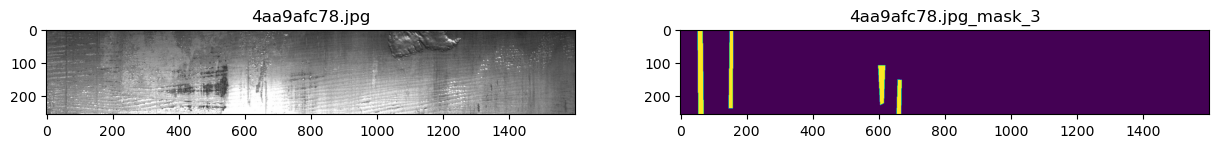

Класс дефекта: 4


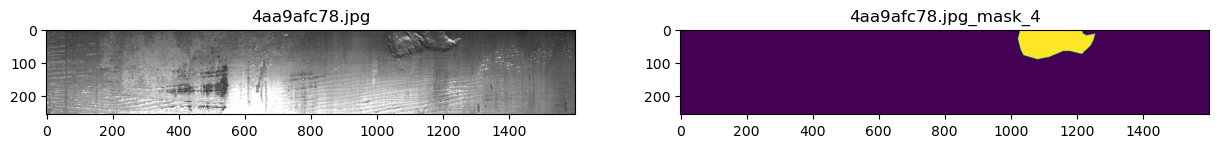

In [22]:
# Визуализируем классы дефектов
for k in [1, 2, 3, 4]:
    tmp = full_train_df[full_train_df['ClassId'] == k]
    cnt = 0
    print(f"Класс дефекта: {k}")
    for i in tmp[['ImageId', 'EncodedPixels']].values:
        if cnt < 1:
            fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
            # Colab
            # img_path = os.path.join('/content/dataset/train_images', i[0])
            img_path = os.path.join(train_folder, i[0])
            img = Image.open(img_path)
            ax1.imshow(img)
            ax1.set_title(i[0])
            cnt += 1
            mask = rle2mask(i[1]) # Преобразуем закодированные пиксели (RLE) в маску.
            ax2.imshow(mask)
            ax2.set_title(f"{i[0]}_mask_{k}")
            plt.show()

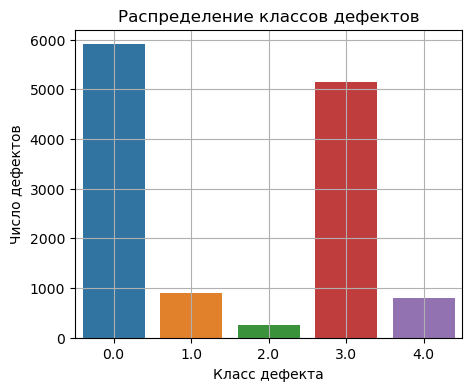

Числовая сводка : 

0 Класс: 5902
1 Класс: 897
2 Класс: 247
3 Класс: 5150
4 Класс: 801

Размер full_train_df:  12997


In [23]:
class_counts = full_train_df['ClassId'].value_counts()

# Создание графика
plt.figure(figsize=(5, 4))
plt.title("Распределение классов дефектов")
sns.barplot(x=class_counts.index, y=class_counts)
plt.ylabel("Число дефектов")
plt.xlabel("Класс дефекта")
plt.grid()
plt.show()

# Вывод числовой информации
print("Числовая сводка : \n")
for i in range(class_counts.shape[0]):
    count = class_counts.get(i, 0)
    print(f"{i} Класс: {count}")

print("\nРазмер full_train_df: ", full_train_df.shape[0])

Обратим внимание, что в наших данных есть изображения `ImageId` которые относятся сразу к нескольким классам дефектов, рассмотрим их отдельно:

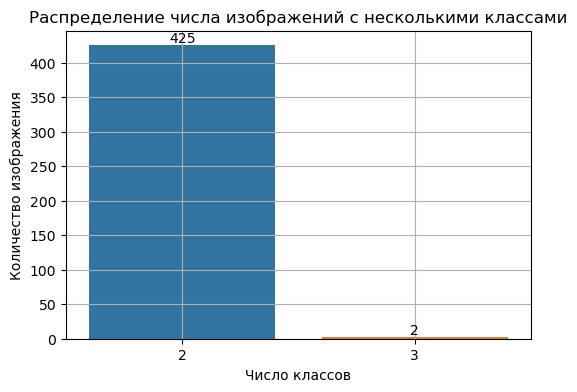

In [24]:
# Группировка по ImageId и подсчет количества изображений относящихся к нескольким классам
data = full_train_df.groupby('ImageId')['ImageId'].count().sort_values(ascending=False)

data_cnt = data.value_counts()
data_cnt = data_cnt[data_cnt.index > 1]

plt.figure(figsize=(6, 4))
plt.title("Распределение числа изображений с несколькими классами")
sns.barplot(x=data_cnt.index, y=data_cnt.values)
plt.xlabel("Число классов")
plt.ylabel("Количество изображения")
plt.grid(True)

for i in range(len(data_cnt)):
    plt.text(x=i, y=data_cnt.values[i], s=str(data_cnt.values[i]), ha='center', va='bottom')

plt.show()

In [25]:
def visualize_images_with_masks(full_train_df, data, train_folder, n_samples=5):
    """
    Визуализация изображений с масками для каждого класса.

    params:
    full_train_df (DataFrame): Датафрейм с данными изображений и масок.
    data (Series): Серия с количеством классов для каждого изображения.
    train_folder (str): Путь к папке с изображениями.
    n_samples (int): Количество образцов для визуализации.
    """
    sampled_data = data.head(n_samples)

    for image_id, class_count in sampled_data.items():
        print(f"Изображение: {image_id}")
        print(f"Число дефектов: {class_count}")

        fig, axs = plt.subplots(1, class_count + 1, figsize=(15, 7))

        # Загрузка изображения
        img_path = os.path.join(train_folder, image_id)
        img = Image.open(img_path)
        axs[0].imshow(img)
        axs[0].set_title("Изображение")

        # Визуализация масок для каждого класса
        masks = full_train_df[full_train_df['ImageId'] == image_id]

        for i, (idx, mask_data) in enumerate(masks.iterrows()):
            mask = rle2mask(mask_data['EncodedPixels'])
            axs[i + 1].imshow(mask)
            axs[i + 1].set_title(f"Класс {int(mask_data['ClassId'])}")


        plt.show()

Изображение: ef24da2ba.jpg
Число дефектов: 3


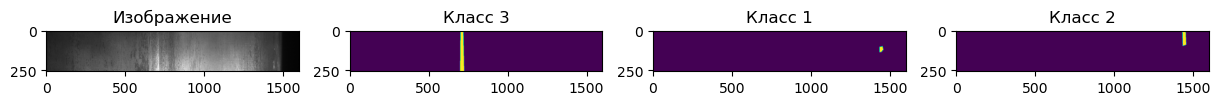

Изображение: db4867ee8.jpg
Число дефектов: 3


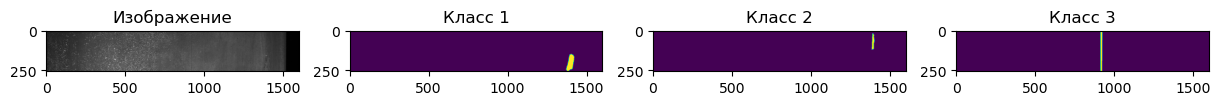

Изображение: 7f30b9c64.jpg
Число дефектов: 2


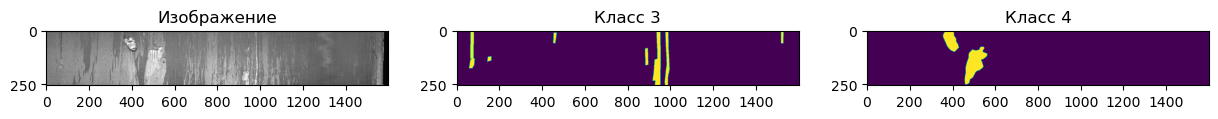

Изображение: 3b8d1d356.jpg
Число дефектов: 2


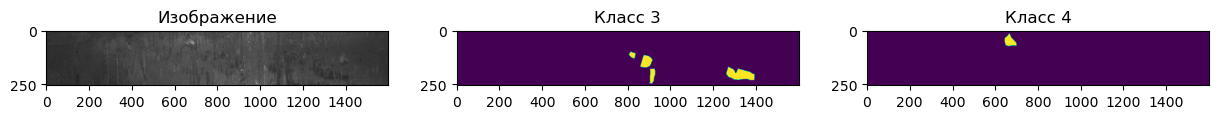

In [26]:
visualize_images_with_masks(full_train_df, data, train_folder, n_samples=4)

Таким образом выделяются 4 основных типа дефектов:
- **Риски - класс 1**. Дефект поверхности имеет вид одного или нескольких продольных
углублений;
- **Царапины - класс 2**. Дефект поверхности имеет вид канавок неправильной формы и произвольного направления;
- **Рябизна или остатки окалины - класс 3**. Дефект поверхности представляет собой светлые штрихи, вытянутые вдоль прокатки, имеет групповой характер;
- **Отпечатки - класс 4**. Дефект поверхности, представляющий собой углубления или выступы, расположенные по всей поверхности металла или на отдельных ее участках.

### 3.2 Распределение площадей дефектов по каждому классу

Посчитаем суммарную площадь дефекта для каждого изображения

In [27]:
full_train_df['area'] = full_train_df['EncodedPixels'].apply(lambda s: sum([int(k) for k in str(s).split(' ')[1::2]]))

In [28]:
# Выведем основную статистику по дефектам
full_train_df.groupby('ClassId')['area'].describe()

,count,mean,std,min,25%,50%,75%,max
ClassId,,,,,,,,
0.0,5902.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0
1.0,897.0,4361.347826,3591.053407,163.0,1762.00,3326.0,5795.0,31303.0
2.0,247.0,3378.425101,2049.382114,316.0,1947.50,2944.0,4337.5,14023.0
3.0,5150.0,25496.485243,37945.334103,115.0,5054.25,11953.5,29029.5,368240.0
4.0,801.0,34373.997503,29590.265099,491.0,13114.00,25357.0,45221.0,192780.0


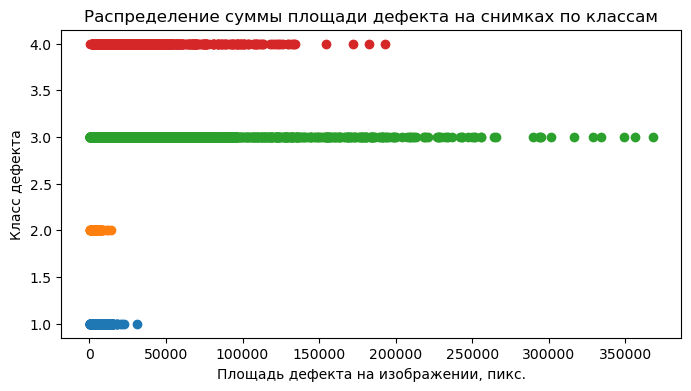

In [29]:
plt.figure(figsize=(8,4))
for i in [1,2,3,4]:
    tmp = full_train_df[full_train_df['ClassId'] == i]['area']
    plt.plot(tmp, np. zeros_like(tmp)+i,'o')
plt.title('Распределение суммы площади дефекта на снимках по классам')
plt.xlabel('Площадь дефекта на изображении, пикс.')
plt.ylabel('Класс дефекта')
plt.show()

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def get_plots_outliers(dataset, cols, cls):
    """
    Для отображения аномальных значений используем диапазон квантилей (0.996) и (0.75 + 1,5xIQR).
    """
    # Преобразование inf в NaN и удаление строк с NaN
    dataset_clean = dataset.replace([np.inf, -np.inf], np.nan).dropna()
    
    for column in cols:
        # Визуализация
        fig, ax = plt.subplots(figsize=(12, 3))
        sns.histplot(data=dataset_clean, x=column, bins=50, kde=True, ax=ax)
        ax.set_ylabel("Количество")

        # Граница по 0.996 и 0.004 квантилю
        upper_first = dataset_clean[column].quantile(0.996)
        lower_first = dataset_clean[column].quantile(0.004)

        upper_outliers_size_first = dataset_clean[column][dataset_clean[column] > upper_first].size
        percent_first = upper_outliers_size_first / dataset_clean[column].size

        lower_outliers_size_first = dataset_clean[column][dataset_clean[column] < lower_first].size
        percent_first_lower = lower_outliers_size_first / dataset_clean[column].size

        ax.axvline(upper_first, color="r", linestyle=":")
        ax.text(
            upper_first, 0.99, "0.996 квантиль", color="r", ha="right", va="top",
            rotation=90, transform=ax.get_xaxis_transform()
        )

        ax.axvline(lower_first, color="r", linestyle=":")
        ax.text(
            lower_first, 0.99, "0.004 квантиль", color="r", ha="right", va="top",
            rotation=90, transform=ax.get_xaxis_transform()
        )

        # Граница по 0.75 + 1,5xIQR
        upper_q = dataset_clean[column].quantile(0.75)
        lower_q = dataset_clean[column].quantile(0.25)
        iqr = upper_q - lower_q
        cut_off = iqr * 1.5
        upper_second = upper_q + cut_off

        upper_outliers_size_second = dataset_clean[column][dataset_clean[column] > upper_second].size
        percent_second = upper_outliers_size_second / dataset_clean[column].size

        ax.axvline(upper_second, color="g", linestyle=":")
        ax.text(
            upper_second, 0.99, "0.75 квантиль + 1,5xIQR", color="g", ha="right", va="top",
            rotation=90, transform=ax.get_xaxis_transform()
        )

        plt.title(f'Распределение суммарной площади дефекта на изображении для класса {cls}')
        plt.show()

        print(f"{column}:")
        print(f"0.996 квантиль: значение {upper_first:.1f}, кол-во выбросов: {upper_outliers_size_first}, доля: {percent_first:.4f}")
        print(f"0.004 квантиль: значение {lower_first:.1f}, кол-во выбросов: {lower_outliers_size_first}, доля: {percent_first_lower:.4f}")
        print(f"0.75 квантиль + 1.5xIQR: значение {upper_second:.1f}, кол-во выбросов: {upper_outliers_size_second}, доля: {percent_second:.4f}")
        print()

C:\Users\Admin\anaconda3\envs\severstal\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


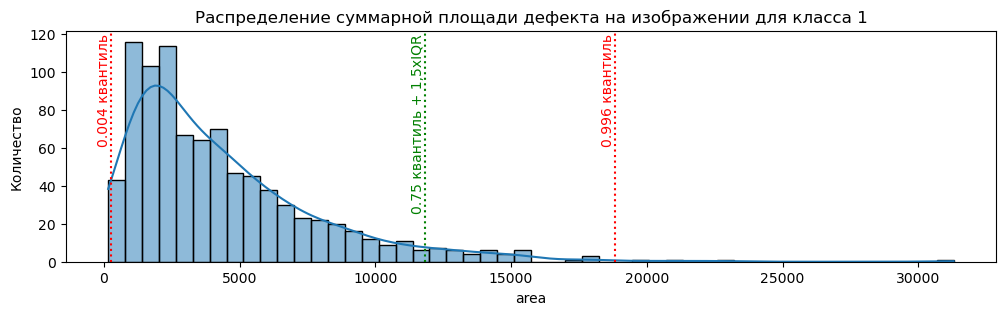

C:\Users\Admin\anaconda3\envs\severstal\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


area:
0.996 квантиль: значение 18820.8, кол-во выбросов: 4, доля: 0.0045
0.004 квантиль: значение 278.0, кол-во выбросов: 4, доля: 0.0045
0.75 квантиль + 1.5xIQR: значение 11844.5, кол-во выбросов: 42, доля: 0.0468



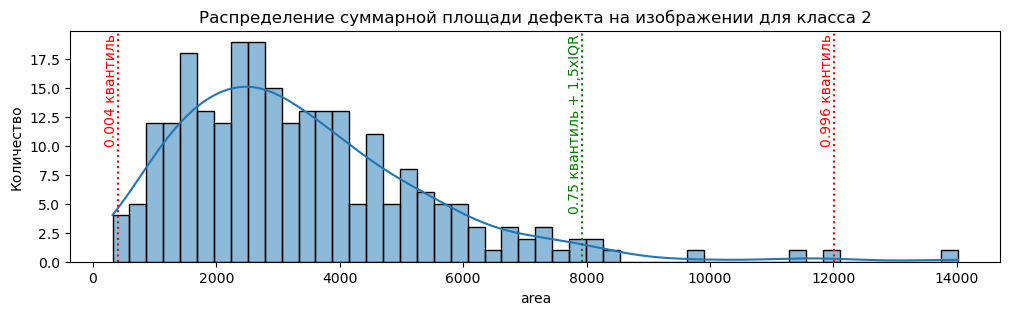

area:
0.996 квантиль: значение 12005.8, кол-во выбросов: 1, доля: 0.0040
0.004 квантиль: значение 403.6, кол-во выбросов: 1, доля: 0.0040
0.75 квантиль + 1.5xIQR: значение 7922.5, кол-во выбросов: 7, доля: 0.0283



C:\Users\Admin\anaconda3\envs\severstal\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


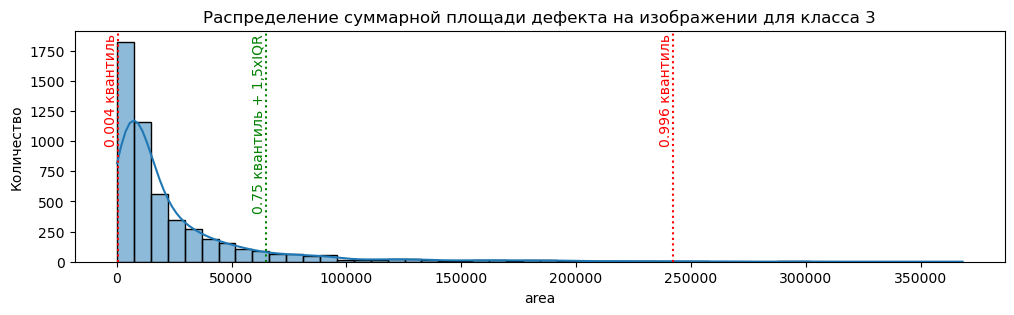

area:
0.996 квантиль: значение 242335.2, кол-во выбросов: 21, доля: 0.0041
0.004 квантиль: значение 412.2, кол-во выбросов: 21, доля: 0.0041
0.75 квантиль + 1.5xIQR: значение 64992.4, кол-во выбросов: 484, доля: 0.0940



C:\Users\Admin\anaconda3\envs\severstal\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


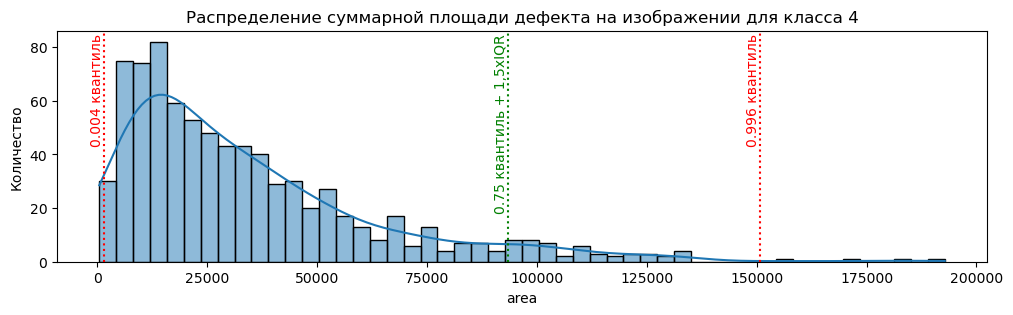

area:
0.996 квантиль: значение 150668.6, кол-во выбросов: 4, доля: 0.0050
0.004 квантиль: значение 1623.6, кол-во выбросов: 4, доля: 0.0050
0.75 квантиль + 1.5xIQR: значение 93381.5, кол-во выбросов: 51, доля: 0.0637



In [31]:
for cls in [1,2,3,4]:
    get_plots_outliers(full_train_df[full_train_df['ClassId'] == cls], ['area'], cls)

Дефекты на распределениях имеют разный диапазон площадей. Минимальная площадь для каждого типа дефекта близка к площади других типов дефектов, тогда как максимальная площадь различается между типами дефектов.

В процессе обучения как вариант можно использовать минимальные и максимальные значения площадей дефектов для создания порогов, которые будут применяться к предсказаниям дефектов на тестовых изображениях. Это поможет улучшить точность предсказаний, отфильтровывая потенциальные ошибки и шум в предсказаниях.

In [32]:
quantiles = []
for cls in [1,2,3,4]:
    tmp = np.array(full_train_df[full_train_df['ClassId'] == cls]['area'].sort_values().values)
    quantiles.append([int(np.quantile(tmp, 0.004)), int(np.quantile(tmp, 0.996))])
print('Ограниченные значения площади дефекта для каждого класса: \n', quantiles)

Ограниченные значения площади дефекта для каждого класса: 
 [[278, 18820], [403, 12005], [412, 242335], [1623, 150668]]


In [33]:
display(full_train_df.sample(10))
full_train_df.shape

,ImageId,defect,ClassId,EncodedPixels,area
139,2ec8d4b22.jpg,0,0.0,0,0
2309,951af566d.jpg,0,0.0,0,0
9940,44ad9ef30.jpg,1,3.0,326944 13 327200 26 327456 27 327518 13 327712...,5562
1339,3a783fae3.jpg,0,0.0,0,0
2504,b02923eea.jpg,0,0.0,0,0
12038,1f7e9363d.jpg,1,3.0,94290 20 94544 24 94798 27 95053 30 95243 5 95...,50004
9877,905328741.jpg,1,3.0,18486 4 18736 10 18986 16 19235 23 19485 28 19...,17116
9084,cbfeaed02.jpg,1,4.0,67239 21 67491 47 67745 60 68000 63 68255 66 6...,36230
3666,3f400c81f.jpg,0,0.0,0,0
5035,64fd46742.jpg,0,0.0,0,0


(12997, 5)

In [34]:
# Выведем диапазоны площадей дефектов по каждому классу
area_thr = pd.DataFrame([[300, 18800],[400, 12000],[400, 242000], [1600, 150000]],
                               columns=['min','max'], index=['defect_1','defect_2','defect_3','defect_4'])
area_thr

,min,max
defect_1,300,18800
defect_2,400,12000
defect_3,400,242000
defect_4,1600,150000


In [35]:
# Сохраним предобработанный df с плщадами дефекта
full_train_df.to_csv('full_train_df_area.csv', index=False)

## 4 Разделение на фолды

In [36]:
full_train_df_pvt = pd.pivot_table(full_train_df, values='EncodedPixels', index='ImageId', columns='ClassId', aggfunc='sum').astype(str)
full_train_df_pvt = full_train_df_pvt.reset_index()
full_train_df_pvt.columns = ['ImageId','EncodedPixels_0', 'EncodedPixels_1','EncodedPixels_2','EncodedPixels_3','EncodedPixels_4']

In [37]:
# Создадим столбец с метками классов
tmp = []
for i in range(len(full_train_df_pvt)):
    if full_train_df_pvt['EncodedPixels_1'].iloc[i] != 'nan':
        tmp.append(1)
    elif full_train_df_pvt['EncodedPixels_2'].iloc[i] != 'nan':
        tmp.append(2)
    elif full_train_df_pvt['EncodedPixels_3'].iloc[i] != 'nan':
        tmp.append(3)
    elif full_train_df_pvt['EncodedPixels_4'].iloc[i] != 'nan':
        tmp.append(4)
    else:
        tmp.append(0)
full_train_df_pvt['class'] = tmp

In [38]:
# Разобьем стратифицированно данные на 5 фолдов, которые далее будем делить на train/val
np.random.seed(100)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
t = full_train_df_pvt['class']

for i, (_, v_ind) in enumerate(kf.split(full_train_df_pvt, t)):
    full_train_df_pvt.loc[full_train_df_pvt.index[v_ind], 'stratifiedkfold'] = i

In [39]:
# Изменим тип данных
full_train_df_pvt[['class', 'stratifiedkfold']] = full_train_df_pvt[['class', 'stratifiedkfold']].astype("Int64")

In [40]:
# Распределение объектов по фолдам
display(full_train_df_pvt['stratifiedkfold'].value_counts())

stratifiedkfold
0    2514
2    2514
1    2514
4    2513
3    2513
Name: count, dtype: Int64

In [41]:
display(full_train_df_pvt.head(5))
full_train_df_pvt.shape

,ImageId,EncodedPixels_0,EncodedPixels_1,EncodedPixels_2,EncodedPixels_3,EncodedPixels_4,class,stratifiedkfold
0,0002cc93b.jpg,nan,29102 12 29346 24 29602 24 29858 24 30114 24 3...,nan,nan,nan,1,0
1,00031f466.jpg,0,nan,nan,nan,nan,0,4
2,000418bfc.jpg,0,nan,nan,nan,nan,0,3
3,000789191.jpg,0,nan,nan,nan,nan,0,2
4,0007a71bf.jpg,nan,nan,nan,18661 28 18863 82 19091 110 19347 110 19603 11...,nan,3,3


(12568, 8)

In [42]:
# Проверим равномерность разбиения данных по фолдам
check_df = full_train_df_pvt.groupby(['stratifiedkfold', 'class'])['class'].agg('count').to_frame().rename(columns={'class': 'count'}).reset_index()
check_df_pvt = check_df.pivot(index='stratifiedkfold', columns='class', values='count')
display(check_df_pvt)

class,0,1,2,3,4
stratifiedkfold,,,,,
0,1180,180,42,1009,103
1,1180,180,42,1009,103
2,1181,179,42,1008,104
3,1181,179,42,1008,103
4,1180,179,42,1009,103


In [43]:
# Т.к дефектов на изображении может быть исходя из данных сразу два (3 дефекта в 2 случаях - не учитываем)
# Посмотрим как распределились комбинации дефектов по фолдам
columns = ['EncodedPixels_1', 'EncodedPixels_2', 'EncodedPixels_3', 'EncodedPixels_4']
combinations = list(itertools.combinations(columns, 2))

# Создание сводной таблицы
summary = []

for fold in range(0, 5):
    fold_data = full_train_df_pvt[full_train_df_pvt['stratifiedkfold'] == fold]
    for combo in combinations:
        count = fold_data[(fold_data[combo[0]] != 'nan') & (fold_data[combo[1]] != 'nan')].shape[0]
        summary.append({'Fold': fold, 'comb': f"{combo[0]} и {combo[1]}", 'cnt': count})

summary_df = pd.DataFrame(summary)

# Вывод сводной таблицы
pivot_table = summary_df.pivot(index='Fold', columns='comb', values='cnt')
display(pivot_table)

comb,EncodedPixels_1 и EncodedPixels_2,EncodedPixels_1 и EncodedPixels_3,EncodedPixels_1 и EncodedPixels_4,EncodedPixels_2 и EncodedPixels_3,EncodedPixels_2 и EncodedPixels_4,EncodedPixels_3 и EncodedPixels_4
Fold,,,,,,
0,3,15,0,4,1,57
1,12,19,0,4,0,51
2,6,18,0,0,0,63
3,10,22,0,4,0,54
4,6,19,0,4,0,59


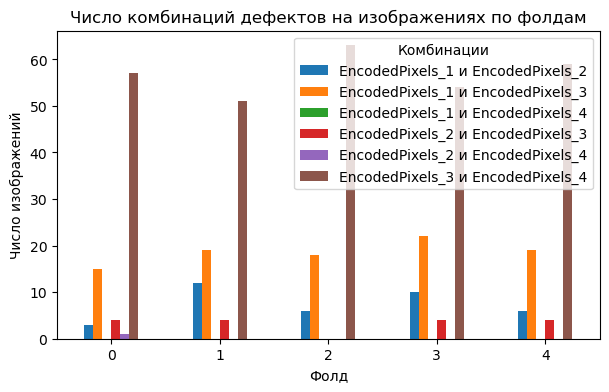

In [44]:
# Построение графика
pivot_table.plot(kind='bar', figsize=(7, 4), title='Число комбинаций дефектов на изображениях по фолдам')
plt.xlabel('Фолд')
plt.ylabel('Число изображений')
plt.xticks(rotation=0)
plt.legend(title='Комбинации')
plt.show()

In [45]:
# Схема данных
# train(12_568 (уник. изобр-я) ---> [6_666 (уник. изобр-я с дефектами)] ---> 7_095 (изобр-я с дефектами) |---> 897 (1 класс)
#           |                                                                                            |---> 247 (2 класс) 
#           |                                                                                            |---> 5_150 (3 класс)
#           |                                                                                            |---> 801 (4 класс)
#           |              
#           |              
#           | ------------------------------------------------------------> 5_902 (уник. изобр-я без дефекта 0 класс)
#           |
#           |
#           |---> 5 фолдлов:
#                             0 класс  1 класс  2 класс 3 класс 4 класс
#                     0 фолд     1_180	  180	   42	   1_009	    103
#                     1 фолд	 1_180	  180	   42	   1_009	    103
#                     2 фолд	 1_181	  179	   42	   1_008	    104
#                     3 фолд	 1_181	  179	   42	   1_008        103
#                     4 фолд	 1_180	  179	   42	   1_009	    103
# 
# 
# test(5_506 (уник. изобр-я)

In [46]:
# Сохраним предобработанный df с фолдами
full_train_df_pvt.to_csv('full_train_df_folds.csv', index=False)

## 5 Выводы по первичному анализу

1. Датасет несбалансированный. Для разбиения на тренировочную и тестовую выборку использовали стратификацию;
2. Некоторые изображения могут на себе нести несколько классов дефектов


Решение задачи многоклассовой сегментации.

План действий:

1 Строим бинарную классификационную модель для фильтрации изображений с дефектами от изображений без дефектов.

2 Строим модель классификации с четырьмя метками для предсказания вероятностей принадлежности изображений к каждому классу дефектов.
   ~После того как получим вероятность того, что изображение содержит определенный класс дефекта, мы будем использовать пороговые значения для этих вероятностей, чтобы принять решение, считать ли предсказанный дефект действительным. Правда еще нужно подобрать эти пороги вероятностей по roc  кривой (np.sqrt(tpr * (1 - fpr))) - наилучший баланс между ложными положительными и ложными отрицательными результатами.~

3 Четыре модели сегментации. Для каждого класса дефектов будем использовать отдельные модели сегментации для генерации масок для каждого тестового изображения.

4 Останется конвертировать маски в формат EncodedPixels (для представления масок в формате строк) и отфильтровать на основе вероятностей, предсказанных классификационными моделями.